In [1]:
import os
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.io as io

import matplotlib.pyplot as plt
import seaborn as sns

from constants import SPATIAL, TEMPORAL, MORPHOLOGICAL
from constants import feature_names_org as feature_names
from perm_test import calc_perm_test

In [2]:
pd.options.display.max_columns = 500

In [3]:
PATH = 'cluster_data/clusterData_no_light_29_03_22/0'

df = None
files = os.listdir(PATH)
for file in sorted(files):
    if df is None:
        df = pd.read_csv(PATH + '/' + file)
        if df.label[0] < 0:
            df = None
    else:
        temp = pd.read_csv(PATH + '/' + file)
        if temp.label[0] < 0:
            continue
        df = df.append(temp)

df = df[feature_names]

In [4]:
mod_d = {'spatial': SPATIAL[:-1], 'temporal': TEMPORAL[:-1], 'morphological': MORPHOLOGICAL[:-1],
        'modalities': SPATIAL[:-1] + TEMPORAL[:-1] + MORPHOLOGICAL[:-1]}

spatial_families = {'value-based': ['spatial_dispersion_count', 'spatial_dispersion_sd', 'spatial_dispersion_area'],
                  'time_based': ['dep_red', 'dep_sd','fzc_red', 'fzc_sd', 'szc_red', 'szc_sd'],
                  'graph-based': ['dep_graph_avg_speed', 'dep_graph_slowest_path', 'dep_graph_fastest_path',
                           'fzc_graph_avg_speed', 'fzc_graph_slowest_path', 'fzc_graph_fastest_path',
                           'szc_graph_avg_speed', 'szc_graph_slowest_path', 'szc_graph_fastest_path']}

temporal_families = {'short': ['d_kl_start', 'unif_dist', 'rise_time'],
                     'long': ['d_kl_mid', 'jump'],
                     'wb': ['firing_rate', 'psd_center', 'der_psd_center']}

morph_families = {'WF': ['trough2peak', 'peak2peak', 'fwhm', 'rise_coef'],
                  'first': ['max_speed'],
                  'second': ['break_measure', 'smile_cry', 'get_acc']}

modality_families = {'spatial': [feature_names[i] for i in SPATIAL[:-1]],
                     'temporal': [feature_names[i] for i in TEMPORAL[:-1]],
                     'morphological': [feature_names[i] for i in MORPHOLOGICAL[:-1]]}

families_d = {'spatial': spatial_families, 'temporal': temporal_families, 'morphological': morph_families,
              'modalities': modality_families}

In [5]:
event_families = {'fzc': ['fzc_red', 'fzc_sd','fzc_graph_avg_speed', 'fzc_graph_slowest_path', 'fzc_graph_fastest_path'],
                  'dep': ['dep_red', 'dep_sd','dep_graph_avg_speed', 'dep_graph_slowest_path', 'dep_graph_fastest_path'],
                  'szc': ['szc_red', 'szc_sd','szc_graph_avg_speed', 'szc_graph_slowest_path', 'szc_graph_fastest_path']}

event_inds = [i for i in mod_d['spatial'] if 'spatial_dispersion' not in feature_names[i]]

mod_d['events'] = event_inds
families_d['events'] = event_families

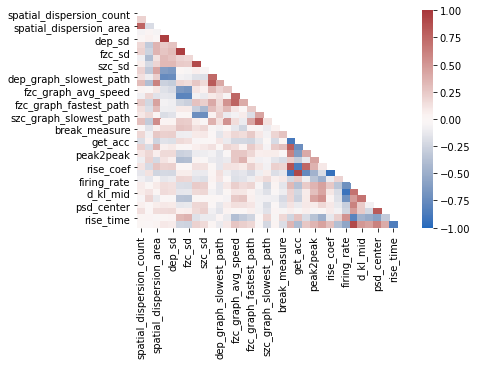

In [6]:
corr_mat = df.corr(method="spearman")
mask = np.triu(np.ones_like(corr_mat, dtype=bool))
plt.yticks(rotation=30)
cmap = sns.color_palette("vlag", as_cmap=True)

_ = sns.heatmap(corr_mat, annot=False, fmt='.2f', mask=mask, vmin=-1, vmax=1, cmap=cmap,
                    annot_kws={"fontsize": 1})

plt.show()

In [7]:
# this is for a specific correlation we state in the Results chapter
print('the correlation between uniform distance and dkl_long is:', corr_mat['unif_dist'].d_kl_start)

the correlation between uniform distance and dkl_long is: 0.9094384434259164


In [8]:
for mod in mod_d:
    print(mod)
    
    mod_mat = corr_mat.loc[[feature_names[i] for i in mod_d[mod]], [feature_names[i] for i in mod_d[mod]]].abs()
    mod_np = mod_mat.to_numpy()
    mask = np.triu(np.ones_like(mod_np, dtype=bool))
    mod_np = mod_np[~mask]
    print(f'    median (IQR) correlation: {np.median(mod_np): .3f} ({np.quantile(mod_np, 0.25): .3f}, {np.quantile(mod_np, 0.75): .3f})')
    print()
    
    for fam in families_d[mod]:
        fam_mat = mod_mat.loc[families_d[mod][fam], families_d[mod][fam]].to_numpy()
        mask = np.triu(np.ones_like(fam_mat, dtype=bool))
        fam_mat = fam_mat[~mask].flatten()
        if len(fam_mat) > 0:
            print(f'    median (IQR) correlation of {fam}: {np.median(fam_mat): .3f} ({np.quantile(fam_mat, 0.25): .3f}, {np.quantile(fam_mat, 0.75): .3f})')
        else:
            print(f'    median (IQR) correlation of {fam}: None (None None)')        
    print()
        
    for i, fam1 in enumerate(families_d[mod]):
        for j, fam2 in enumerate(families_d[mod]):
            if i >= j:
                continue
            cross_mat = mod_mat.loc[families_d[mod][fam1], families_d[mod][fam2]].to_numpy().flatten()
            print(f'    median (IQR) correlation of {fam1} X {fam2}: {np.median(cross_mat): .3f} ({np.quantile(cross_mat, 0.25): .3f}, {np.quantile(cross_mat, 0.75): .3f})')    
    print()

spatial
    median (IQR) correlation:  0.203 ( 0.098,  0.332)

    median (IQR) correlation of value-based:  0.208 ( 0.204,  0.490)
    median (IQR) correlation of time_based:  0.285 ( 0.244,  0.332)
    median (IQR) correlation of graph-based:  0.237 ( 0.122,  0.420)

    median (IQR) correlation of value-based X time_based:  0.153 ( 0.054,  0.243)
    median (IQR) correlation of value-based X graph-based:  0.198 ( 0.120,  0.312)
    median (IQR) correlation of time_based X graph-based:  0.171 ( 0.080,  0.278)

temporal
    median (IQR) correlation:  0.524 ( 0.378,  0.695)

    median (IQR) correlation of short:  0.850 ( 0.828,  0.879)
    median (IQR) correlation of long:  0.694 ( 0.694,  0.694)
    median (IQR) correlation of wb:  0.278 ( 0.257,  0.547)

    median (IQR) correlation of short X long:  0.491 ( 0.466,  0.513)
    median (IQR) correlation of short X wb:  0.548 ( 0.480,  0.611)
    median (IQR) correlation of long X wb:  0.243 ( 0.235,  0.587)

morphological
    median (

In [9]:
wf_mat = corr_mat.loc[[feature_names[i] for i in mod_d['morphological']],[feature_names[i] for i in mod_d['morphological']]].abs()
wf_np = wf_mat.to_numpy()
mask_wf = np.triu(np.ones_like(wf_np, dtype=bool))
wf_np = wf_np[~mask_wf]

temp_mat = corr_mat.loc[[feature_names[i] for i in mod_d['temporal']],[feature_names[i] for i in mod_d['temporal']]].abs()
temp_np = temp_mat.to_numpy()
mask_temp = np.triu(np.ones_like(temp_np, dtype=bool))
temp_np = temp_np[~mask_temp]

spat_mat = corr_mat.loc[[feature_names[i] for i in mod_d['spatial']],[feature_names[i] for i in mod_d['spatial']]].abs()
spat_np = spat_mat.to_numpy()
mask_spat = np.triu(np.ones_like(spat_np, dtype=bool))
spat_np = spat_np[~mask_spat]

print('correlation differences between modalities')
print(f'TEMP-SPAT p-value={calc_perm_test(temp_np, spat_np, reps=1000)}\n')
print(f'WF-SPAT p-value={calc_perm_test(wf_np, spat_np, reps=1000)}\n')


correlation differences between modalities
TEMP-SPAT p-value=0.000999000999000999

WF-SPAT p-value=0.000999000999000999



spatial
Median (IQR) correlation of spatial_dispersion_count:  0.144 ( 0.082,  0.210)
Median (IQR) correlation of spatial_dispersion_sd:  0.208 ( 0.166,  0.301)
Median (IQR) correlation of spatial_dispersion_area:  0.221 ( 0.129,  0.433)
Median (IQR) correlation of dep_red:  0.192 ( 0.066,  0.323)
Median (IQR) correlation of dep_sd:  0.205 ( 0.087,  0.314)
Median (IQR) correlation of fzc_red:  0.241 ( 0.178,  0.308)
Median (IQR) correlation of fzc_sd:  0.230 ( 0.150,  0.314)
Median (IQR) correlation of szc_red:  0.203 ( 0.114,  0.286)
Median (IQR) correlation of szc_sd:  0.214 ( 0.112,  0.330)
Median (IQR) correlation of dep_graph_avg_speed:  0.314 ( 0.065,  0.433)
Median (IQR) correlation of dep_graph_slowest_path:  0.172 ( 0.135,  0.230)
Median (IQR) correlation of dep_graph_fastest_path:  0.293 ( 0.181,  0.418)
Median (IQR) correlation of fzc_graph_avg_speed:  0.171 ( 0.106,  0.332)
Median (IQR) correlation of fzc_graph_slowest_path:  0.134 ( 0.082,  0.195)
Median (IQR) correlation 

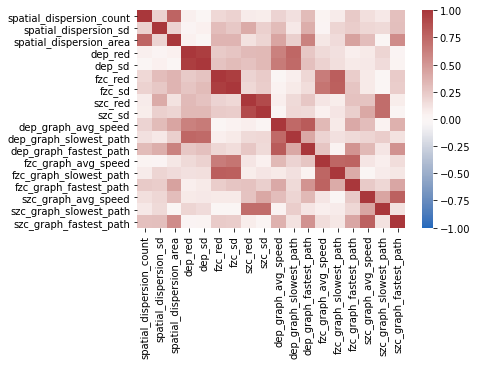

temporal
Median (IQR) correlation of firing_rate:  0.548 ( 0.404,  0.705)
Median (IQR) correlation of d_kl_start:  0.688 ( 0.545,  0.758)
Median (IQR) correlation of d_kl_mid:  0.502 ( 0.353,  0.691)
Median (IQR) correlation of jump:  0.480 ( 0.340,  0.605)
Median (IQR) correlation of psd_center:  0.593 ( 0.260,  0.611)
Median (IQR) correlation of der_psd_center:  0.312 ( 0.240,  0.440)
Median (IQR) correlation of rise_time:  0.531 ( 0.489,  0.700)
Median (IQR) correlation of unif_dist:  0.548 ( 0.475,  0.730)


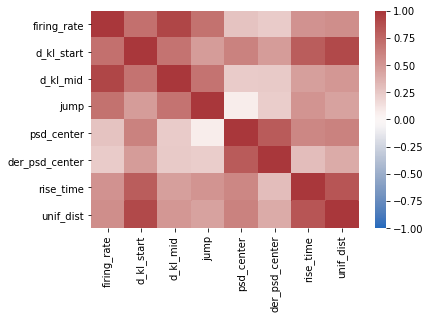

morphological
Median (IQR) correlation of break_measure:  0.189 ( 0.076,  0.237)
Median (IQR) correlation of fwhm:  0.807 ( 0.446,  0.872)
Median (IQR) correlation of get_acc:  0.726 ( 0.460,  0.871)
Median (IQR) correlation of max_speed:  0.726 ( 0.357,  0.758)
Median (IQR) correlation of peak2peak:  0.450 ( 0.387,  0.542)
Median (IQR) correlation of trough2peak:  0.200 ( 0.158,  0.260)
Median (IQR) correlation of rise_coef:  0.754 ( 0.277,  0.861)
Median (IQR) correlation of smile_cry:  0.762 ( 0.330,  0.909)


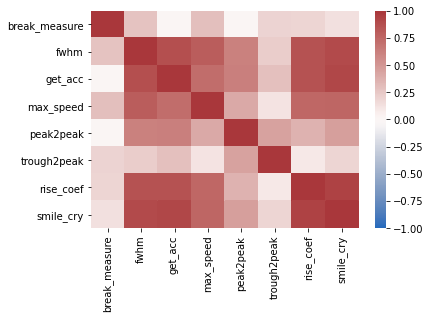

modalities
Median (IQR) correlation of spatial_dispersion_count:  0.114 ( 0.074,  0.187)
Median (IQR) correlation of spatial_dispersion_sd:  0.181 ( 0.053,  0.208)
Median (IQR) correlation of spatial_dispersion_area:  0.193 ( 0.066,  0.310)
Median (IQR) correlation of dep_red:  0.159 ( 0.090,  0.213)
Median (IQR) correlation of dep_sd:  0.153 ( 0.087,  0.225)
Median (IQR) correlation of fzc_red:  0.203 ( 0.095,  0.280)
Median (IQR) correlation of fzc_sd:  0.210 ( 0.090,  0.273)
Median (IQR) correlation of szc_red:  0.164 ( 0.090,  0.240)
Median (IQR) correlation of szc_sd:  0.172 ( 0.097,  0.220)
Median (IQR) correlation of dep_graph_avg_speed:  0.068 ( 0.018,  0.314)
Median (IQR) correlation of dep_graph_slowest_path:  0.137 ( 0.115,  0.172)
Median (IQR) correlation of dep_graph_fastest_path:  0.132 ( 0.094,  0.293)
Median (IQR) correlation of fzc_graph_avg_speed:  0.175 ( 0.114,  0.259)
Median (IQR) correlation of fzc_graph_slowest_path:  0.147 ( 0.092,  0.239)
Median (IQR) correlati

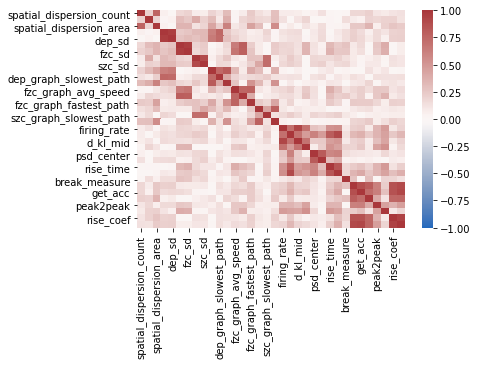

events
Median (IQR) correlation of dep_red:  0.253 ( 0.143,  0.331)
Median (IQR) correlation of dep_sd:  0.280 ( 0.151,  0.326)
Median (IQR) correlation of fzc_red:  0.234 ( 0.113,  0.268)
Median (IQR) correlation of fzc_sd:  0.230 ( 0.105,  0.304)
Median (IQR) correlation of szc_red:  0.231 ( 0.128,  0.286)
Median (IQR) correlation of szc_sd:  0.225 ( 0.127,  0.333)
Median (IQR) correlation of dep_graph_avg_speed:  0.321 ( 0.050,  0.566)
Median (IQR) correlation of dep_graph_slowest_path:  0.183 ( 0.145,  0.371)
Median (IQR) correlation of dep_graph_fastest_path:  0.263 ( 0.173,  0.397)
Median (IQR) correlation of fzc_graph_avg_speed:  0.204 ( 0.124,  0.565)
Median (IQR) correlation of fzc_graph_slowest_path:  0.123 ( 0.082,  0.336)
Median (IQR) correlation of fzc_graph_fastest_path:  0.257 ( 0.192,  0.409)
Median (IQR) correlation of szc_graph_avg_speed:  0.218 ( 0.092,  0.327)
Median (IQR) correlation of szc_graph_slowest_path:  0.143 ( 0.071,  0.221)
Median (IQR) correlation of szc

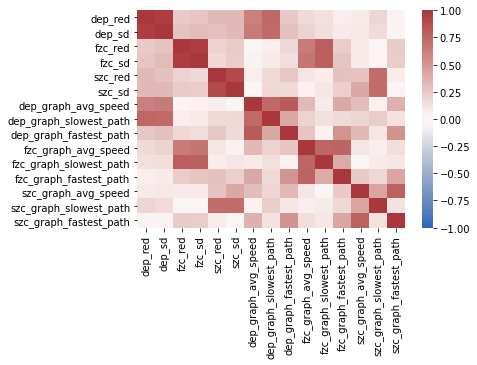

In [10]:
for mod in mod_d:
    print(mod)
    mod_mat = corr_mat.loc[[feature_names[i] for i in mod_d[mod]],[feature_names[i] for i in mod_d[mod]]].abs()
    mod_np = mod_mat.to_numpy()
    
    for i, col in enumerate(mod_mat.columns):
        col_cor = mod_mat[[col]].to_numpy()
        col_cor = np.concatenate((col_cor[:i], col_cor[i + 1:]), axis=0)

        print(f'Median (IQR) correlation of {col}: {np.median(col_cor): .3f} ({np.quantile(col_cor, 0.25): .3f}, {np.quantile(col_cor, 0.75): .3f})')
    
    _ = sns.heatmap(mod_mat, annot=False, fmt='.2f', vmin=-1, vmax=1, cmap=cmap, annot_kws={"fontsize": 1})

    plt.show()

In [11]:
for mod in mod_d:
    print(mod)
    mod_mat = corr_mat.loc[[feature_names[i] for i in mod_d[mod]],[feature_names[i] for i in mod_d[mod]]].abs()
    
    intra_fam = []
    for fam in families_d[mod]:
        fam_mat = mod_mat.loc[families_d[mod][fam], families_d[mod][fam]].to_numpy()
        mask = np.triu(np.ones_like(fam_mat, dtype=bool))
        fam_mat = fam_mat[~mask].flatten()
        intra_fam.append(fam_mat)
    intra_fam = np.concatenate(intra_fam)        
    
    inter_fam = []
    for i, fam1 in enumerate(families_d[mod]):
        for j, fam2 in enumerate(families_d[mod]):
            if i >= j:
                continue
            cross_mat = mod_mat.loc[families_d[mod][fam1], families_d[mod][fam2]].to_numpy().flatten()
            inter_fam.append(cross_mat)
    inter_fam = np.concatenate(inter_fam)
    
    print(f'Median (IQR) correlation of intra-family: {np.median(intra_fam): .4f} ({np.quantile(intra_fam, 0.25): .4f}, {np.quantile(intra_fam, 0.75): .4f})')
    print(f'Median (IQR) correlation of inter-family: {np.median(inter_fam): .4f} ({np.quantile(inter_fam, 0.25): .4f}, {np.quantile(inter_fam, 0.75): .4f})')
    print(f'p-value={calc_perm_test(intra_fam, inter_fam, reps=1000)}\n')


spatial
Median (IQR) correlation of intra-family:  0.2698 ( 0.1696,  0.4166)
Median (IQR) correlation of inter-family:  0.1725 ( 0.0836,  0.2936)
p-value=0.002997002997002997

temporal
Median (IQR) correlation of intra-family:  0.8068 ( 0.4858,  0.8325)
Median (IQR) correlation of inter-family:  0.5018 ( 0.4005,  0.6105)
p-value=0.007992007992007992

morphological
Median (IQR) correlation of intra-family:  0.3653 ( 0.1394,  0.6181)
Median (IQR) correlation of inter-family:  0.4657 ( 0.2374,  0.7843)
p-value=0.37362637362637363

modalities
Median (IQR) correlation of intra-family:  0.2444 ( 0.1275,  0.4796)
Median (IQR) correlation of inter-family:  0.1278 ( 0.0684,  0.2016)
p-value=0.000999000999000999

events
Median (IQR) correlation of intra-family:  0.6674 ( 0.3192,  0.7728)
Median (IQR) correlation of inter-family:  0.1706 ( 0.0897,  0.2454)
p-value=0.000999000999000999



In [12]:
non_short = ['d_kl_mid', 'jump', 'firing_rate', 'psd_center', 'der_psd_center']
non_short_corrs = corr_mat.loc[non_short, non_short].to_numpy()
mask = np.triu(np.ones_like(non_short_corrs, dtype=bool))
non_short_corrs = non_short_corrs[~mask].flatten()

short = ['d_kl_start', 'unif_dist', 'rise_time']
short_corrs = corr_mat.loc[short, short].to_numpy()
mask = np.triu(np.ones_like(short_corrs, dtype=bool))
short_corrs = short_corrs[~mask].flatten()

print(f'p-value={calc_perm_test(abs(short_corrs), abs(non_short_corrs), reps=1000)}\n')
print(f'Median (IQR) correlation of non-high-freq: {np.median(abs(non_short_corrs)): .3f} ({np.quantile(abs(non_short_corrs), 0.25): .3f}, {np.quantile(abs(non_short_corrs), 0.75): .3f})')

p-value=0.052947052947052944

Median (IQR) correlation of non-high-freq:  0.261 ( 0.237,  0.699)
